# Library / Packages

In [1]:
# basic library
import os
import pandas as pd
import numpy as np
import sys

# graph
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# complex math
from scipy import stats

# pickle and .env
from dotenv import dotenv_values
import pickle

# Format

In [2]:
def lab_round(x, pos): 
    if abs(x) >= 1e9: 
        return f'{x/1e9} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3} K'
    
    else:
        return f'{x}'
    
def val_round(x):
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6:.2f} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3:.2f} K'
    
    else:
        return f'{x:.2f}'

# Data Source

In [3]:
# parameter
share = {**dotenv_values('../.env.shared')} 

# read pickle
with open(share['PREPARATION_DATA'], 'rb') as f:
    loaded_data = pickle.load(f)

market_df = pd.DataFrame(loaded_data)
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   test_group     588101 non-null  object
 1   converted      588101 non-null  bool  
 2   total_ads      588101 non-null  int64 
 3   most_ads_day   588101 non-null  object
 4   most_ads_hour  588101 non-null  int64 
 5   week_cat       588101 non-null  object
dtypes: bool(1), int64(2), object(3)
memory usage: 27.5+ MB


# Data Visualization

## Basic Analyst

In [4]:
# filter data for descriptive analyst
#===============================
descriptive_data = market_df.select_dtypes(include = ['number'])

# Deskripsi statistik
#===============================
description = descriptive_data.describe(include = 'all').map(val_round)

mode = descriptive_data.mode().iloc[0].map(val_round)
variance = descriptive_data.var().map(val_round)
range_ = (descriptive_data.max() - descriptive_data.min()).map(val_round)
iqr = stats.iqr(descriptive_data)
coefficient_of_variation = (descriptive_data.std() / descriptive_data.mean()).map(val_round)
skewness = descriptive_data.skew().map(val_round)
kurtosis = descriptive_data.kurtosis().map(val_round)

# add data into description descriptive
#=======================================
description.loc['mode'] = mode
description.loc['variance'] = variance
description.loc['range'] = range_
description.loc['IQR'] = val_round(iqr)
description.loc['Coefficient of Variation'] = coefficient_of_variation
description.loc['Skewness'] = skewness
description.loc['Kurtosis'] = kurtosis

description

,total_ads,most_ads_hour
count,588.10 K,588.10 K
mean,24.82,14.47
std,43.72,4.83
min,1.00,0.00
25%,4.00,11.00
50%,13.00,14.00
75%,27.00,18.00
max,2.06 K,23.00
mode,1.00,13.00
variance,1.91 K,23.37


## Histogram

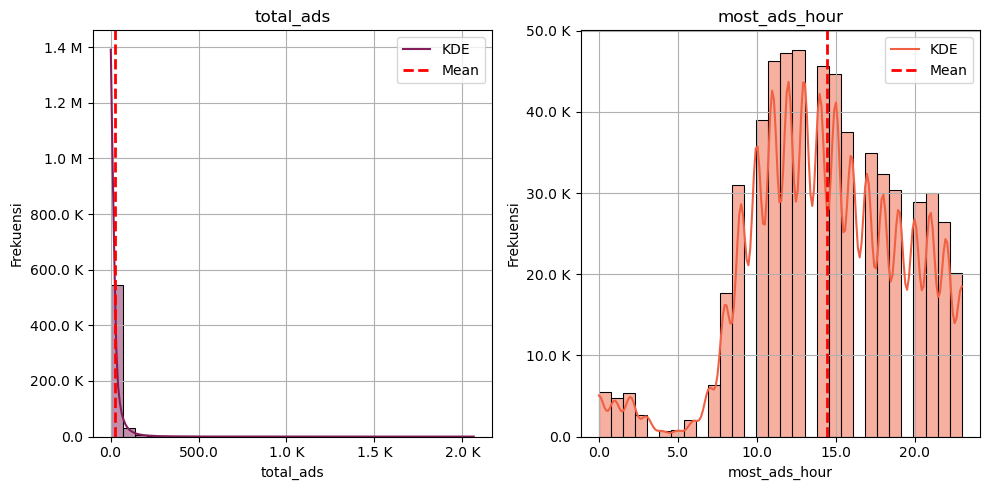

In [5]:
# Data
hist_data = market_df.select_dtypes(include = ['number'])

# Set up subplot grid
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

# Flatten axes for easy iteration
ax = ax.flatten()

# Get number of columns in hist_data
num_cols = len(hist_data.columns)

# Generate colors from a colormap with enough colors for each subplot
colors = sns.color_palette("rocket", num_cols)

# Plot each histogram
for i, column in enumerate(hist_data.columns):
    sns.histplot(hist_data[column], bins = 30, kde = True, color = colors[i], edgecolor = 'black', ax = ax[i])
    ax[i].set_title(column)
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Frekuensi')

    # Adding vertical line for mean
    ax[i].axvline(x=hist_data[column].mean(), color = 'red', linestyle = '--', linewidth = 2)

    # Add legend
    ax[i].legend(['KDE', 'Mean'], loc = 'upper right')

     # Applying format_number function to the ylabel
    ax[i].xaxis.set_major_formatter(ticker.FuncFormatter(lab_round))
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lab_round))
    ax[i].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Outlier Check

In [6]:
rows = market_df.shape[0]
cols = market_df.shape[1]

if rows <= 1000 and cols <= 20:
    category = "Small Dataset"

elif rows <= 100000 and cols <= 100:
    category = "Medium Dataset"

elif rows <= 1000000 and cols <= 500:
    category = "Large Dataset"

elif rows <= 10000000 and cols <= 1000:
    category = "Very Large Dataset"

else:
    category = "Massive Dataset"

print(f'Rows: {val_round(rows)}, Columns: {val_round(cols)}, then Dataset Category: {category.upper()}!!!')

Rows: 588.10 K, Columns: 6.00, then Dataset Category: LARGE DATASET!!!


### Z-Score Methode

A normal distribution is shown below and it is estimated that 68% of the data points lie between +/- 1 standard deviation. 95% of the data points lie between +/- 2 standard deviation 99.7% of the data points lie between +/- 3 standard deviation

In [7]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   test_group     588101 non-null  object
 1   converted      588101 non-null  bool  
 2   total_ads      588101 non-null  int64 
 3   most_ads_day   588101 non-null  object
 4   most_ads_hour  588101 non-null  int64 
 5   week_cat       588101 non-null  object
dtypes: bool(1), int64(2), object(3)
memory usage: 27.5+ MB


In [8]:
# Data
sample_columns = market_df.select_dtypes(include=['number']).columns  # Ambil nama kolom sebagai array
sample_data = market_df[sample_columns]  # Gunakan kolom tersebut untuk indexing

# Set a threshold
threshold = 2

# Loop untuk memeriksa setiap kolom satu persatu
for col in sample_columns:
    # Data kolom
    col_data = sample_data[col]

    # Calculate Z-Score untuk kolom ini
    z_scores = (col_data - col_data.mean()) / col_data.std()

    # Filter out outliers
    outliers = col_data[np.abs(z_scores) >= threshold]
    non_outliers = col_data[np.abs(z_scores) < threshold]

    # Menampilkan hasil secara terstruktur untuk setiap kolom
    print(f"--- {col} ---")
    print(f"Z-Score Summary:")
    print(f"\tMean: {z_scores.mean()}")
    print(f"\tStandard Deviation: {z_scores.std()} \n")
    print(f"Outliers Threshold: {threshold}")
    
    # Menampilkan jumlah outliers dan non-outliers
    print(f"Outliers: {len(outliers)}")
    print(f"Non-Outliers: {len(non_outliers)} \n")
    
    # Tampilkan beberapa outliers dan non-outliers
    print("Sample of Outliers:")
    print(f"{outliers.head()} \n")  # Tampilkan beberapa outliers

    print("Sample of Non-Outliers:")
    print(f"{non_outliers.head()} \n")  # Tampilkan beberapa non-outliers
    print('=' * 40)
    print("\n")  # Spasi antar kolom

# Hasil akhir
print(f"Completed processing for all columns.")


--- total_ads ---
Z-Score Summary:
	Mean: -2.7836893036931937e-17
	Standard Deviation: 1.000000000001974 

Outliers Threshold: 2
Outliers: 18777
Non-Outliers: 569324 

Sample of Outliers:
0    130
3    355
4    276
5    734
6    264
Name: total_ads, dtype: int64 

Sample of Non-Outliers:
1     93
2     21
7     17
8     21
11    47
Name: total_ads, dtype: int64 



--- most_ads_hour ---
Z-Score Summary:
	Mean: 1.357048535550432e-16
	Standard Deviation: 1.0000000000015403 

Outliers Threshold: 2
Outliers: 19072
Non-Outliers: 569029 

Sample of Outliers:
24    3
31    4
46    0
60    2
72    4
Name: most_ads_hour, dtype: int64 

Sample of Non-Outliers:
0    20
1    22
2    18
3    10
4    14
Name: most_ads_hour, dtype: int64 



Completed processing for all columns.


### IQR Methode

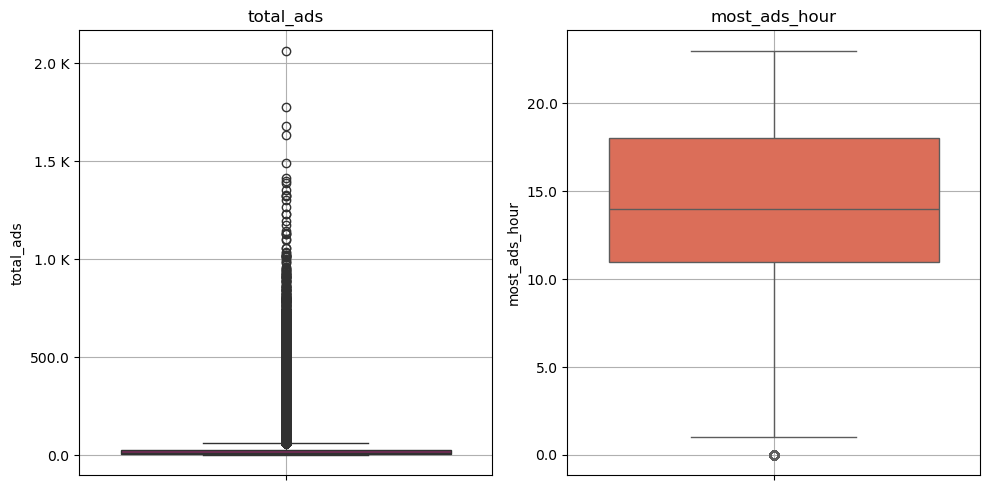

In [9]:
# Data
box_data = market_df.select_dtypes(include = ['number'])

# Set up subplot grid
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

# Flatten axes for easy iteration
ax = ax.flatten()

# Get number of columns in hist_data
num_cols = len(box_data.columns)

# Generate colors from a colormap with enough colors for each subplot
colors = sns.color_palette("rocket", num_cols)

# Create boxplots for each column
for i, col in enumerate(box_data.columns):
    sns.boxplot(y = col, data = box_data, ax = ax[i], color = colors[i])
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lab_round))
    ax[i].set_title(col)
    ax[i].grid(axis = 'both')

#
plt.tight_layout()

# Show plot
plt.show()

In [10]:
# DataFrame columns to check for outliers
columns_to_check = ['total_ads', 'most_ads_hour']

# Function to calculate IQR and filter outliers
def filter_outliers(df, columns):
    while True:
        outlier_indices = set()
        
        for col in columns:
            Q1 = np.percentile(df[col], 25, method = 'midpoint')
            Q3 = np.percentile(df[col], 75, method = 'midpoint')
            IQR = Q3 - Q1
            
            upper_bound = Q3 + 1.5 * IQR
            lower_bound = Q1 - 1.5 * IQR
            
            col_outliers = df[(df[col] >= upper_bound) | (df[col] <= lower_bound)].index
            outlier_indices.update(col_outliers)
        
        # If no outliers are found, break the loop
        if not outlier_indices:
            break
        
        # Remove outliers
        df.drop(index=outlier_indices, inplace=True)
    
    return df

# Apply the function
market_df_cleaned = filter_outliers(market_df.copy(), columns_to_check)

# Display the old and new shape of the DataFrame
print(f'Old Shape: {market_df.shape}')
print(f'New Shape: {market_df_cleaned.shape}')

Old Shape: (588101, 6)
New Shape: (493927, 6)


In [11]:
# clean data
market_df = market_df_cleaned.copy()

Re-Check

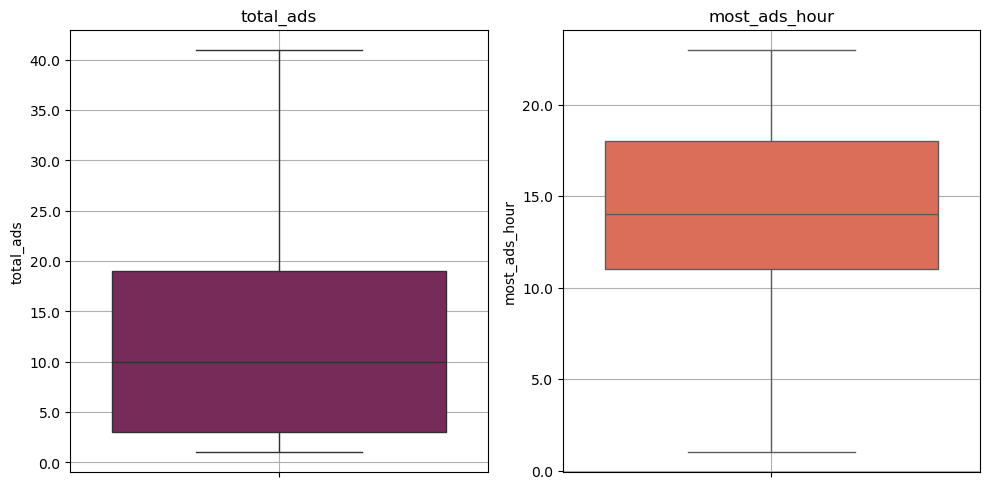

In [12]:
# Data
box_data = market_df.select_dtypes(include = ['number'])

# Set up subplot grid
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

# Flatten axes for easy iteration
ax = ax.flatten()

# Get number of columns in hist_data
num_cols = len(box_data.columns)

# Generate colors from a colormap with enough colors for each subplot
colors = sns.color_palette("rocket", num_cols)

# Create boxplots for each column
for i, col in enumerate(box_data.columns):
    sns.boxplot(y = col, data = box_data, ax = ax[i], color = colors[i])
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lab_round))
    ax[i].set_title(col)
    ax[i].grid(axis = 'both')

#
plt.tight_layout()

# Show plot
plt.show()

## Basic Visualization

### Heatmap

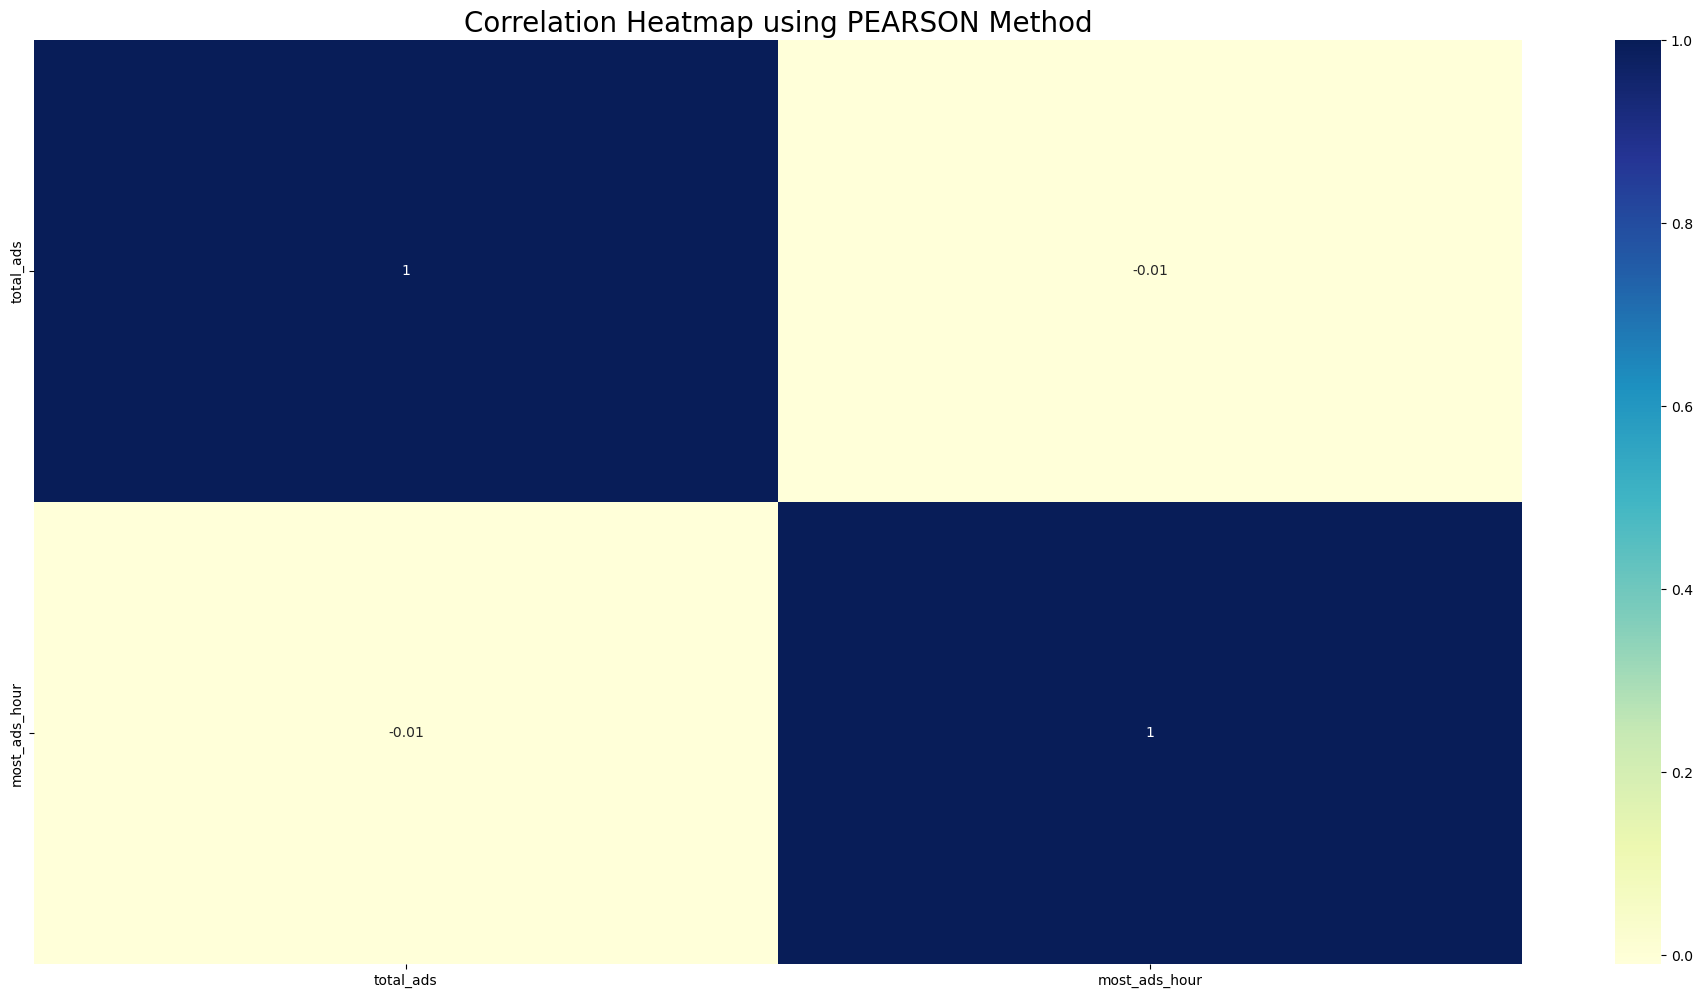

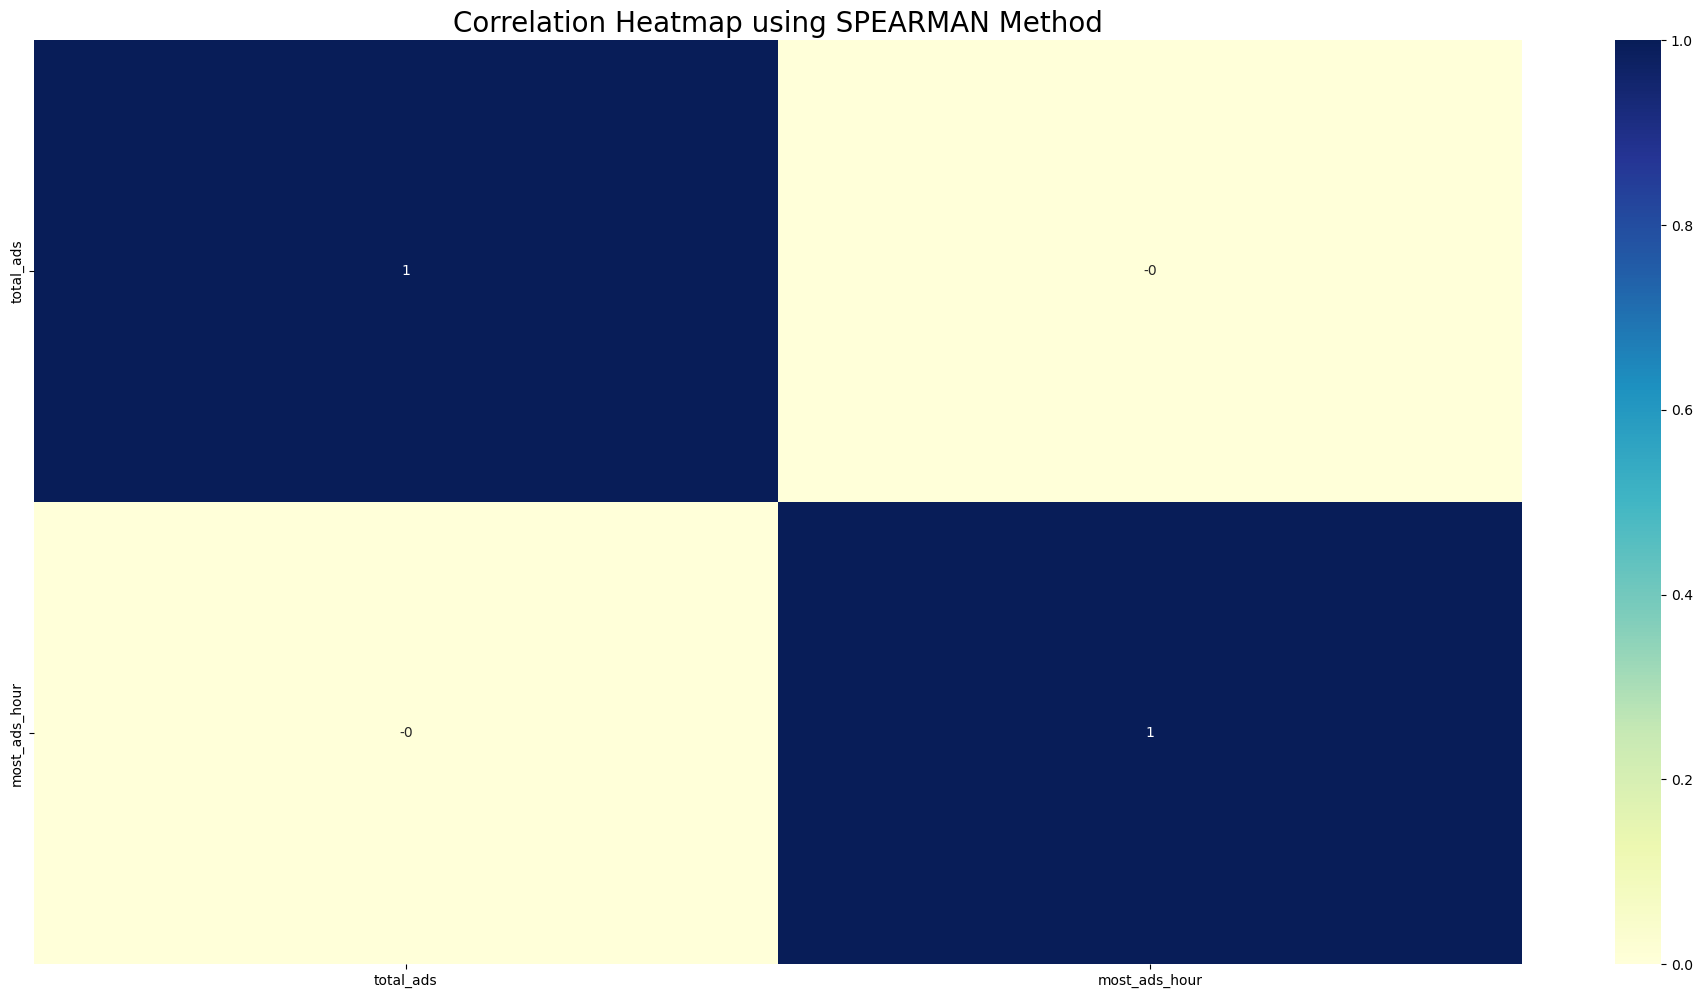

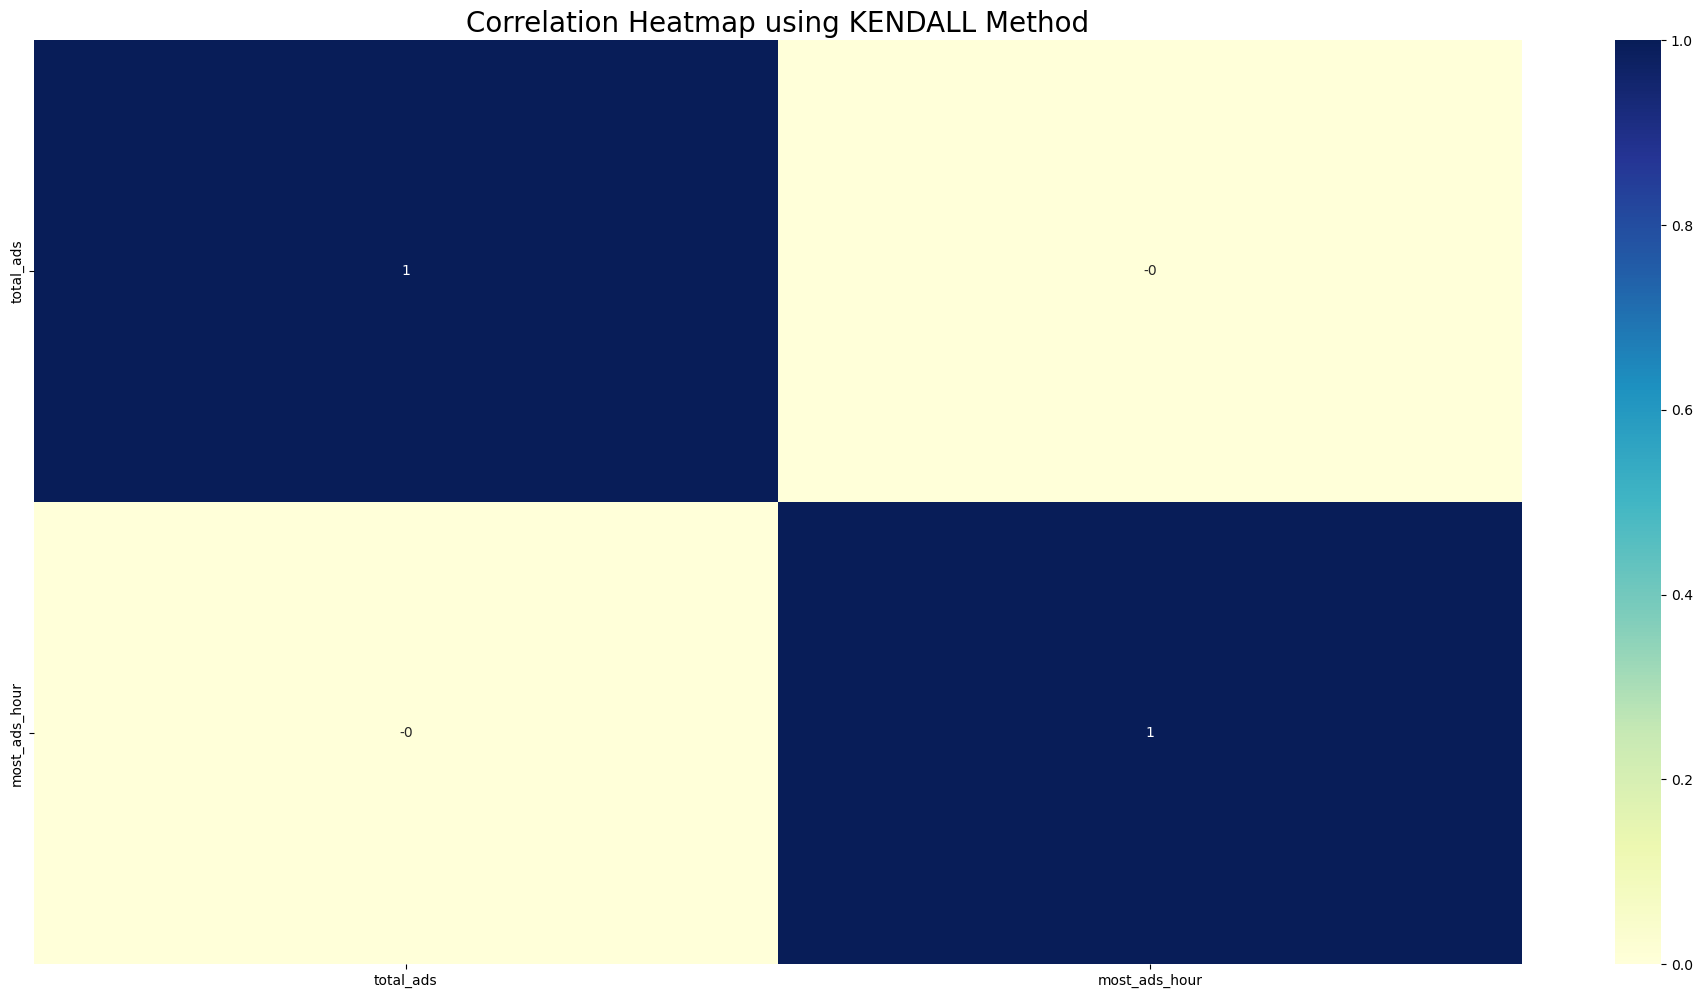

In [13]:
# Date & Numeric Correlations
correlations_data = market_df.select_dtypes(include = 'number')

# List of correlation methods to be used
sample_methods = ['pearson', 'spearman', 'kendall']

# Plotting correlation heatmap for each method
for method in sample_methods:
    # Creat canvas
    plt.figure(figsize = (24, 12))  # Set the figure size for each heatmap
    plt.title(f'Correlation Heatmap using {method.upper()} Method', fontsize = 20)

    # Calculate correlation for the current method
    corr_matrix = correlations_data.corr(method = method).round(2)

    # Plot heatmap
    sns.heatmap(corr_matrix, cmap = "YlGnBu", annot = True)
    plt.show()

# Data Mart

In [14]:
market_df.columns

Index(['test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour',
       'week_cat'],
      dtype='object')

In [15]:
# Nama direktori
dir_name = '../datamart'

# Mengecek apakah direktori sudah ada
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    print(f"Directory '{dir_name}' created.")

else:
    print(f"Directory '{dir_name}' already exists.")

Directory '../datamart' already exists.


In [16]:
# calculate dataframe size
total_size_bytes = sys.getsizeof(market_df)

# Converse bytes to MB
total_size_mb = total_size_bytes / 1048576
print(f"Total size of DataFrame: {total_size_mb:.2f} MB")

Total size of DataFrame: 88.63 MB


In [18]:
# save to pickle
with open(share['CLEAN_DATA'], 'wb') as f:
    pickle.dump(market_df, f)

print('Data has been saved')

Data has been saved


# Problem Statement

1. How are the results of the uni-variate analysis?

2. How are the results of the bi-variate analysis?